In [1]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas as gpd
from IPython.display import IFrame
%matplotlib inline
ox.__version__

'1.0.0'

In [2]:
# turn response caching on and turn on logging to your terminal window
ox.config(log_console=True, use_cache=True)

In [4]:
#read the files from the Colonias folder using geopandas just as if we were using only pandas
colonias = gpd.read_file('input_data/coloniasmexico/Colonias/')

In [5]:
#query to filter only the colonias from Merida municipality of Yucatan state
colonias_yucatan_merida = colonias[(colonias['ST_NAME']=='YUCATAN') & (colonias['MUN_NAME'] == 'MÉRIDA')]

In [6]:
colonias_yucatan_merida.head(3)

,OBJECTID,POSTALCODE,ST_NAME,MUN_NAME,SETT_NAME,SETT_TYPE,AREA,Shape_Leng,Shape_Area,geometry
56515,56516,97000,YUCATAN,MÉRIDA,BARRIO SAN SEBASTIAN,FRACCIONAMIENTO,724836804.0,0.028660,0.000038,"POLYGON Z ((-89.63250 20.96072 0.00000, -89.63..."
56516,56517,97000,YUCATAN,MÉRIDA,BARRIO SANTA ANA,FRACCIONAMIENTO,724836804.0,0.031112,0.000051,"POLYGON Z ((-89.62424 20.97568 0.00000, -89.62..."
56517,56518,97000,YUCATAN,MÉRIDA,BARRIO SANTIAGO,FRACCIONAMIENTO,724836804.0,0.023338,0.000034,"POLYGON Z ((-89.62914 20.96978 0.00000, -89.62..."


In [3]:
# save/load graph as a graphml file: this is the best way to save your model
# for subsequent work later
# if you want to work with your model in gephi, use gephi compatibility mode

filepath = './networks/merida-kanasin-road.graphml'
#ox.save_graphml(G, filepath=filepath, gephi=False)
G = ox.load_graphml(filepath)

In [7]:
#extract nodes as a geodataframe
nodes = ox.graph_to_gdfs(G, edges=False)

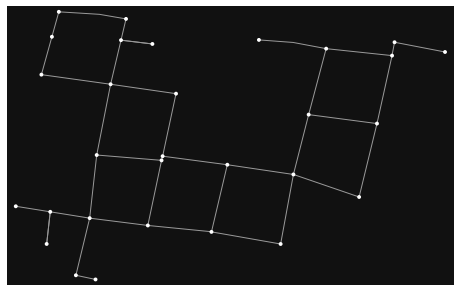

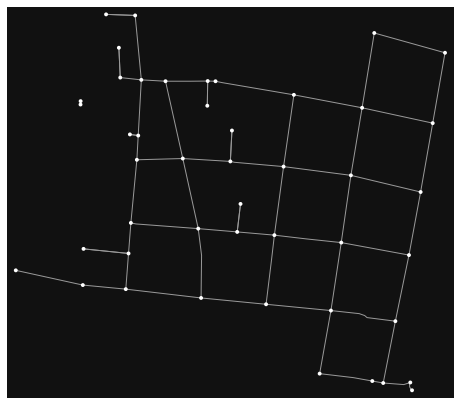

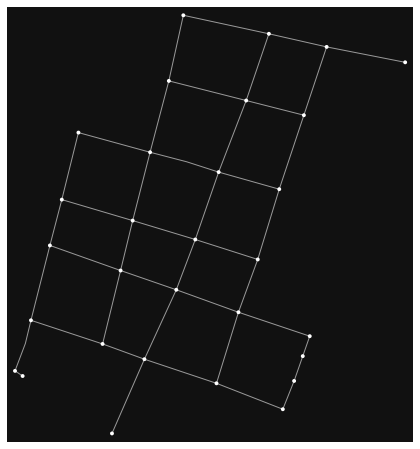

ValueError: Graph has no edges, cannot convert to a GeoDataFrame.

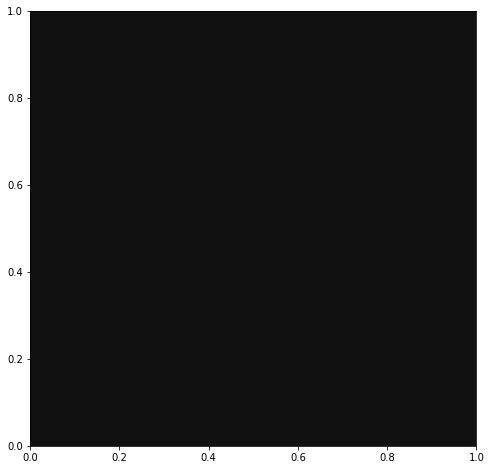

In [9]:
# for each colonia polygon, find intersecting nodes then induce subgraph
for polygon in colonias_yucatan_merida['geometry']:
    intersecting_nodes = nodes[nodes.intersects(polygon)].index
    G_sub = G.subgraph(intersecting_nodes)
    fig, ax = ox.plot_graph(G_sub)